In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# ============================================================
# UTILITIES
# ============================================================
def one_hot(y, num_classes):
    return np.eye(num_classes)[y].T

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [16]:
# ============================================================
# ACTIVATION FUNCTIONS
# ============================================================
class Activation:
    def __init__(self, activation_type):
        self.type = activation_type

    def forward(self, Z):
        self.Z = Z
        if self.type == "relu":
            return np.maximum(0, Z)
        if self.type == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        if self.type == "tanh":
            return np.tanh(Z)
        if self.type == "softmax":
            e = np.exp(Z - np.max(Z, axis=0, keepdims=True))
            return e / np.sum(e, axis=0, keepdims=True)

    def backward(self, dA):
        if self.type == "relu":
            return dA * (self.Z > 0)
        if self.type == "sigmoid":
            s = 1 / (1 + np.exp(-self.Z))
            return dA * s * (1 - s)
        if self.type == "tanh":
            return dA * (1 - np.tanh(self.Z)**2)
        return dA

In [17]:
# ============================================================
# LOSS FUNCTION
# ============================================================
class Loss:
    def __init__(self, loss_type="crossentropy"):
        self.type = loss_type

    def compute(self, y_true, y_pred):
        m = y_true.shape[1]
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)

        if self.type == "crossentropy":
            return -np.sum(y_true * np.log(y_pred)) / m

    def derivative(self, y_true, y_pred):
        return y_pred - y_true


In [18]:
# ============================================================
# OPTIMIZERS
# ============================================================
class Optimizer:
    def __init__(self, opt_type="sgd", lr=0.01, beta=0.9, beta2=0.999, eps=1e-8):
        self.type = opt_type
        self.lr = lr
        self.beta = beta
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.v = {}
        self.s = {}

    def update(self, layer, dW, db):
        if self.type == "sgd":
            layer.W -= self.lr * dW
            layer.b -= self.lr * db
            return

        if self.type == "momentum":
            if layer not in self.v:
                self.v[layer] = {"dW": np.zeros_like(dW), "db": np.zeros_like(db)}
            self.v[layer]["dW"] = self.beta * self.v[layer]["dW"] + (1 - self.beta) * dW
            self.v[layer]["db"] = self.beta * self.v[layer]["db"] + (1 - self.beta) * db
            layer.W -= self.lr * self.v[layer]["dW"]
            layer.b -= self.lr * self.v[layer]["db"]
            return

        if self.type == "adam":
            self.t += 1
            if layer not in self.v:
                self.v[layer] = {"dW": np.zeros_like(dW), "db": np.zeros_like(db)}
                self.s[layer] = {"dW": np.zeros_like(dW), "db": np.zeros_like(db)}

            self.v[layer]["dW"] = self.beta * self.v[layer]["dW"] + (1 - self.beta) * dW
            self.v[layer]["db"] = self.beta * self.v[layer]["db"] + (1 - self.beta) * db

            self.s[layer]["dW"] = self.beta2 * self.s[layer]["dW"] + (1 - self.beta2) * (dW**2)
            self.s[layer]["db"] = self.beta2 * self.s[layer]["db"] + (1 - self.beta2) * (db**2)

            v_corrected_dW = self.v[layer]["dW"] / (1 - self.beta**self.t)
            v_corrected_db = self.v[layer]["db"] / (1 - self.beta**self.t)
            s_corrected_dW = self.s[layer]["dW"] / (1 - self.beta2**self.t)
            s_corrected_db = self.s[layer]["db"] / (1 - self.beta2**self.t)

            layer.W -= self.lr * v_corrected_dW / (np.sqrt(s_corrected_dW) + self.eps)
            layer.b -= self.lr * v_corrected_db / (np.sqrt(s_corrected_db) + self.eps)

In [19]:
# ============================================================
# DENSE LAYER
# ============================================================
class Dense:
    def __init__(self, input_dim, output_dim, activation="relu"):
        if activation == "relu":
            self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2/input_dim)
        else:
            self.W = np.random.randn(output_dim, input_dim) * np.sqrt(1/input_dim)

        self.b = np.zeros((output_dim, 1))
        self.activation = Activation(activation)

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = self.W @ A_prev + self.b
        return self.activation.forward(self.Z)

    def backward(self, dA, optimizer):
        dZ = self.activation.backward(dA)
        m = self.A_prev.shape[1]

        dW = (1/m) * dZ @ self.A_prev.T
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = self.W.T @ dZ

        optimizer.update(self, dW, db)
        return dA_prev

In [20]:
# ============================================================
# MODEL
# ============================================================
class ANN:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def compile(self, loss="crossentropy", optimizer="adam", lr=0.001):
        self.loss = Loss(loss)
        self.optimizer = Optimizer(opt_type=optimizer, lr=lr)

    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, dLoss):
        dA = dLoss
        for layer in reversed(self.layers):
            dA = layer.backward(dA, self.optimizer)

    def fit(self, X, y, epochs=20, batch_size=64, decay=0, verbose=1):
        m = X.shape[1]
        self.losses = []
        self.accuracies = []

        for epoch in range(epochs):
            perm = np.random.permutation(m)
            Xsh = X[:, perm]
            ysh = y[:, perm]

            for i in range(0, m, batch_size):
                Xb = Xsh[:, i:i+batch_size]
                yb = ysh[:, i:i+batch_size]

                y_pred = self.forward(Xb)
                loss = self.loss.compute(yb, y_pred)
                dLoss = self.loss.derivative(yb, y_pred)
                self.backward(dLoss)

            y_pred_full = self.forward(X)
            loss_full = self.loss.compute(y, y_pred_full)
            acc = compute_accuracy(np.argmax(y, axis=0), np.argmax(y_pred_full, axis=0))

            self.losses.append(loss_full)
            self.accuracies.append(acc)

            if decay:
                self.optimizer.lr *= (1 / (1 + decay * epoch))

            if verbose:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {loss_full:.4f} | Acc: {acc*100:.2f}%")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=0)

    def plot(self):
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(self.losses)
        plt.title("Loss")

        plt.subplot(1,2,2)
        plt.plot(self.accuracies)
        plt.title("Accuracy")
        plt.show()



Epoch 1/50 | Loss: 1.1416 | Acc: 29.17%
Epoch 2/50 | Loss: 1.0915 | Acc: 47.50%
Epoch 3/50 | Loss: 1.0343 | Acc: 53.33%
Epoch 4/50 | Loss: 0.9715 | Acc: 60.00%
Epoch 5/50 | Loss: 0.8995 | Acc: 65.83%
Epoch 6/50 | Loss: 0.8244 | Acc: 67.50%
Epoch 7/50 | Loss: 0.7587 | Acc: 67.50%
Epoch 8/50 | Loss: 0.7024 | Acc: 67.50%
Epoch 9/50 | Loss: 0.6542 | Acc: 69.17%
Epoch 10/50 | Loss: 0.6137 | Acc: 69.17%
Epoch 11/50 | Loss: 0.5800 | Acc: 71.67%
Epoch 12/50 | Loss: 0.5522 | Acc: 72.50%
Epoch 13/50 | Loss: 0.5272 | Acc: 73.33%
Epoch 14/50 | Loss: 0.5041 | Acc: 75.83%
Epoch 15/50 | Loss: 0.4836 | Acc: 77.50%
Epoch 16/50 | Loss: 0.4632 | Acc: 78.33%
Epoch 17/50 | Loss: 0.4433 | Acc: 78.33%
Epoch 18/50 | Loss: 0.4242 | Acc: 79.17%
Epoch 19/50 | Loss: 0.4065 | Acc: 79.17%
Epoch 20/50 | Loss: 0.3902 | Acc: 83.33%
Epoch 21/50 | Loss: 0.3750 | Acc: 84.17%
Epoch 22/50 | Loss: 0.3611 | Acc: 87.50%
Epoch 23/50 | Loss: 0.3474 | Acc: 88.33%
Epoch 24/50 | Loss: 0.3356 | Acc: 88.33%
Epoch 25/50 | Loss: 0.324

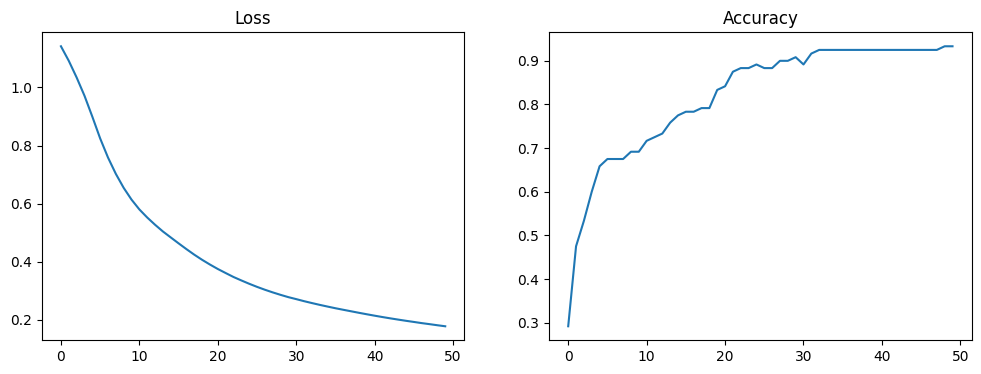

In [21]:


# ============================================================
# USING THE MODEL ON IRIS DATASET
# ============================================================
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris.data
y_raw = iris.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_raw)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y_raw
)

model = ANN()
model.add(Dense(4, 16, "relu"))
model.add(Dense(16, 8, "relu"))
model.add(Dense(8, 3, "softmax"))

model.compile(loss="crossentropy", optimizer="adam", lr=0.001)

model.fit(X_train.T, y_train.T, epochs=50, batch_size=16)

y_pred = model.predict(X_test.T)
y_pred_classes = y_pred

print("Predicted classes:", y_pred_classes)
print("True classes     :", np.argmax(y_test, axis=1))

model.plot()
